In [17]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [18]:
def create_data(ave, var, numbers):
    x = np.random.normal(ave[0], var, numbers)
    y = np.random.normal(ave[1], var, numbers)
    combined = np.vstack((x, y)).T
    return combined
def create_target(label, numbers):
    return  np.full(numbers, label)

In [19]:
dataset1 = create_data([1,1],1,100)
dataset2 = create_data([0,2],1,100)
dataset3 = create_data([-3,4],1,100)

In [20]:
target1 = create_target(0, 100)
target2 = create_target(1, 100)
target3 = create_target(2, 100)

In [21]:
dataset = np.concatenate((dataset1, dataset2, dataset3), axis=0)
target = np.concatenate((target1, target2, target3), axis=0)
dataset.shape

(300, 2)

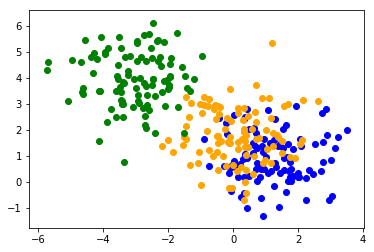

In [22]:
for i in dataset1:
    plt.scatter(i[0],i[1], color='b')
for i in dataset2:
    plt.scatter(i[0],i[1], color='orange')
for i in dataset3:
    plt.scatter(i[0],i[1], color='g')
plt.show()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

# Change Model in here

In [24]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.3):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

class Net(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        k = 64
        self.ln1 = CustomLinear(in_features, k)
        self.ln2 = CustomLinear(k, k)
        self.ln3 = CustomLinear(k, k)
        self.ln4 = CustomLinear(k, out_features)
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        x = F.log_softmax(x,dim=1)
        return x

In [25]:
train_set = torch.utils.data.TensorDataset(X_train, y_train)
test_set = torch.utils.data.TensorDataset(X_test, y_test)
train_set[1]

(tensor([-0.2988,  1.0097]), tensor(1))

In [26]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(test_set)

In [27]:
# network difine
net = Net(in_features=2, out_features=3)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [28]:
train_losses = []
test_losses = []
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    # 検証データの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())
print('Finished Training')



Finished Training


# Loss movement per epoch

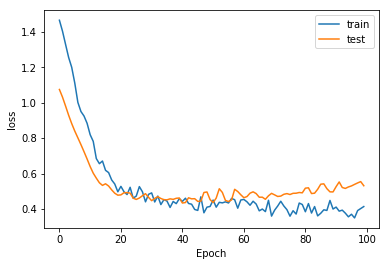

In [29]:
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend()

In [30]:
y_pred = net(X_test)
y_pred[:5]

tensor([[-6.1662e+00, -2.0368e+00, -1.4219e-01],
        [-1.0586e+01, -6.8380e+00, -1.0981e-03],
        [-2.6061e-01, -1.4840e+00, -5.9228e+00],
        [-2.1658e-01, -1.6434e+00, -6.5647e+00],
        [-1.7072e+01, -1.3666e+01, -1.1921e-06]], grad_fn=<SliceBackward>)

In [31]:
y = torch.argmax(y_pred, dim=1)
y

tensor([2, 2, 0, 0, 2, 2, 1, 0, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 2, 2,
        1, 0, 2, 2, 1, 1, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0, 2, 2,
        1, 2, 0, 0, 2, 0, 2, 2, 1, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0, 2, 1, 0, 1, 1,
        2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0])

# Error sample in test dataset

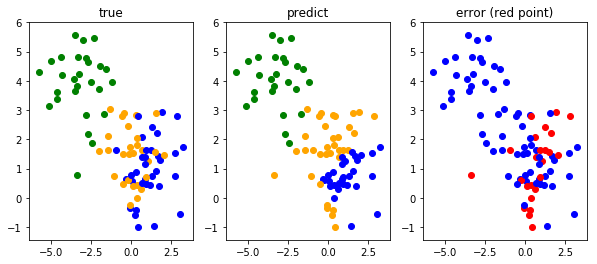

In [32]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.set_title("true")
ax2.set_title("predict")
ax3.set_title("error (red point)")
for i, item in enumerate(X_test):
    label = y_test[i]
    if label==0:
        ax1.scatter(item[0], item[1], color='b')
    elif label==1:
        ax1.scatter(item[0], item[1], color='orange')
    elif label==2:
        ax1.scatter(item[0], item[1], color='green')

for i, item in enumerate(X_test):
    label = y[i]
    if label==0:
        ax2.scatter(item[0], item[1], color='b')
    elif label==1:
        ax2.scatter(item[0], item[1], color='orange')
    elif label==2:
        ax2.scatter(item[0], item[1], color='green')
        
for i, item in enumerate(X_test):
    label = y_test[i]
    pred = y[i]
    if label==pred:
        ax3.scatter(item[0], item[1], color='b')
    else:
        ax3.scatter(item[0], item[1], color='r')

plt.show() 